In [1]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [2]:
# other dependencies
!pip install timm ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
## nnAudio
!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/KinWaiCheuk/nnAudio.git to /tmp/pip-req-build-ppl7sk0z
  Running command git clone -q https://github.com/KinWaiCheuk/nnAudio.git /tmp/pip-req-build-ppl7sk0z
  Resolved https://github.com/KinWaiCheuk/nnAudio.git to commit 744fab12497a5316153978de2e97422c9c7389e0


### 1 Import the kitchen sink

In [4]:
# CUDA magic for reproducability
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [5]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [6]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [7]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import LabelSmoothingCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob

In [8]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [9]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [10]:
def test_model(model, test_loader, criterion, class_threshold=0.5, device=None):
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        test_loss = 0.0
        model.eval()
        
        all_y = []
        all_y_pred = []
        counter = 1
        for x, y, idx in tqdm(test_loader, desc='validation', leave=True):
            
            x, y = x.to(device), y.to(device)
            
            y_pred = model(x)['prediction']
                        
            loss = criterion(y_pred, y)

            test_loss += loss.item()
            
            all_y.append(y.cpu().detach())
            all_y_pred.append(y_pred.cpu().detach())
            
            del x
            del y
            del y_pred
            
            counter +=1

        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), torch.argmax(all_y_pred,dim=1).numpy())
    
    
    return test_loss, test_acc

In [11]:
def train_model(train_loader, val_loader, model = None, n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)

    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    optimiser = timm.optim.create_optimizer_v2(model,opt='lamb',lr=0.001,weight_decay=0.01)
    
    num_steps = len(train_loader)
    num_epochs = config_pytorch.epochs
    
    # 1 cycle Decaying CosineLR per timm train.py
    scheduler = CosineLRScheduler(
            optimiser,
            t_initial=num_epochs,
        cycle_decay=0.5,
        lr_min=1e-6,
        t_in_epochs=True,
        warmup_t=1,
        warmup_lr_init=5e-4,
        cycle_limit=1)
    

    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []
    best_val_loss = np.inf
    best_val_acc = -np.inf

    # best_train_loss = np.inf
    best_train_acc = -np.inf

    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    
    lr_log = []
    
    for e in range(num_epochs):
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            scheduler.step_update(num_updates=global_step)

            x = inputs[0].to(device)
            y = inputs[1].to(device)

            global_step += 1
            
            if len(x) == 1:
                x = x[0]

            optimiser.zero_grad()
            # AMP
            with autocast(enabled=False):
                y_pred = model(x)['prediction']
                loss = criterion(y_pred, y)
                
            loss_scaler(
                loss, optimiser,
                parameters=model_parameters(model))
    

            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            all_y_pred.append(y_pred.cpu().detach())
            
            lr_log.append(optimiser.param_groups[0]['lr'])
            
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            
            del x
            del y
        

        scheduler.step(e+1)
        all_train_loss.append(train_loss/len(train_loader))

        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        train_acc = accuracy_score(all_y.numpy(), torch.argmax(all_y_pred,dim=1).numpy())
        all_train_acc.append(train_acc)


        # Can add more conditions to support loss instead of accuracy. Use *-1 for loss inequality instead of acc
        val_loss, val_acc = test_model(model, val_loader, criterion, 0.5, device=device)
        all_val_loss.append(val_loss)
        all_val_acc.append(val_acc)

        acc_metric = val_acc
        best_acc_metric = best_val_acc
        
        if acc_metric > best_acc_metric:  
            # if checkpoint_name is not None:
                # os.path.join(os.path.pardir, 'models', 'pytorch', checkpoint_name)

            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'

            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            best_epoch = e
#             best_train_acc = train_acc
#             best_train_loss = train_loss
#             if x_val is not None:
            best_val_acc = val_acc
            best_val_loss = val_loss
            overrun_counter = -1

        overrun_counter += 1
        #if x_val is not None:
        print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
#         else:
#             print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [12]:
def evaluate_model(model, test_loader, n_samples, n_channels=3):
    with torch.no_grad():
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f'Evaluating on {device}')

        softmax = nn.Softmax(dim=1)
        
        y_preds_all = torch.zeros([n_samples, len(test_loader.dataset), 2])
        model.eval() # Important to not leak info from batch norm layers and cause other issues
        
        for n in range(n_samples):
            all_y_pred = []
            all_y = []
            for x, y, idx in tqdm(test_loader):
                x, y = x.to(device), y.to(device)

                y_pred = model(x)['prediction']
                all_y.append(y.cpu().detach())

                all_y_pred.append(y_pred.cpu().detach())

                del x
                del y
                del y_pred

            all_y_pred = torch.cat(all_y_pred)
            all_y = torch.cat(all_y)

            y_preds_all[n,:] = softmax(all_y_pred)
#             y_preds_all[n,:,1] = np.array(sigmoid(all_y_pred).squeeze())
#             y_preds_all[n,:,0] = 1-np.array(sigmoid(all_y_pred).squeeze()) # Check ordering of classes (yes/no)
            test_acc = accuracy_score(all_y.numpy(), torch.argmax(all_y_pred,dim=1).numpy())
            print(test_acc)
    return y_preds_all, all_y

In [13]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'index':row.name, 'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate),'sound_type':row['sound_type'], 'length': row['length']})
        elif short_audio:
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
    return pd.DataFrame(audio_offsets)       

In [14]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### 3 The Data

### Read CSV and get train/test groups

In [15]:
df = pd.read_csv(config.data_df)

# To be kept: please do not edit the test set: these paths select test set A, test set B as described in the paper
idx_test_A = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
idx_test_B = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
idx_train = np.logical_not(np.logical_or(idx_test_A, idx_test_B))
df_test_A = df[idx_test_A]
df_test_B = df[idx_test_B]


df_train = df[idx_train]

# Modify by addition or sub-sampling of df_train here
# df_train ... 

# Assertion to check that train does NOT appear in test:
assert len(np.where(pd.concat([df_train,df_test_A,
                               df_test_B]).duplicated())[0]) == 0, 'Train dataframe contains overlap with Test A, Test B'

In [16]:
# come on feel the noise

# first get the length of all the MUSAN noises https://www.openslr.org/17/ --> data/noise
files_noise = glob('../data/noise/**/*.wav')+glob('../data/audioset/*.wav')
df_noise = pd.DataFrame([{'path': f, 'length': torchaudio.sox_effects.apply_effects_file(f, effects=[["rate", f'{config.rate}']])[0].shape[1]/config.rate} for f in tqdm(files_noise)])
# make the noise in the training data match the format
df_noise_train = df_train[(df_train['sound_type']!='mosquito')][['id','length']]
df_noise_train = df_noise_train[df_noise_train['length']>min_length].sample(frac=0.19)
df_noise_train['path'] = df_noise_train['id'].apply(lambda x: os.path.join(config.data_dir,f'{x}.wav'))
df_noise = pd.concat([df_noise,df_noise_train[['path','length']]],ignore_index=True)

0it [00:00, ?it/s]

In [17]:
# use audio clips shorter than min length ?
USE_SHORT_AUDIO = True

In [18]:
# get the frame offsets for each audio file into dataframes
audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
audio_df_test_A = get_offsets_df(df_test_A, short_audio=True)
audio_df_test_B = get_offsets_df(df_test_B, short_audio=True)

  0%|          | 0/7934 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

In [19]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, noise_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "200"],
                ])

            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
                f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            f = f_out.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        #if real_idx % 2 == 0 and self.audio_df.loc[real_idx]['sound_type'] == 'mosquito':
        #if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' and random.randint(0,1)==1:
        if random.randint(0,1)==1:
            sample_length = x.shape[1]/config.rate#sample_length = self.audio_df.loc[real_idx]['length']
            if len(self.noise_df[self.noise_df['length'] >= sample_length]) > 0:
                noise_path = self.noise_df[self.noise_df['length'] >= sample_length].sample(1).iloc[0]['path']
                noise, _ = self._get_sample_(noise_path, resample=config.rate)
                
                noise_length_difference = noise.shape[1]-x.shape[1] 
                
                random_noise_offset = 0 if noise_length_difference==0 else random.randrange(0,noise_length_difference)
                noise = noise[:, random_noise_offset:random_noise_offset+x.shape[1]]

                mos_power = x.norm(p=2)
                noise_power = noise.norm(p=2)

                snr = math.exp(random.randint(2,5) / 10)
                
                scale = snr * noise_power / mos_power
                x = (scale * x + noise) / 2
        
        offset = self.audio_df.loc[real_idx]['offset']
        return (x[:,offset:int(offset+config.rate*self.min_length)], torch.tensor(1) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor(0), idx)


In [20]:
class MozTestDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "200"],
                ])
            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                left_pad_amt = int((config.rate*min_length-waveform.shape[1])//2)
                left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
                right_pad_amt = int(config.rate*min_length-waveform.shape[1]-left_pad_amt)
                right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
                f = torch.cat([left_pad,waveform,right_pad],dim=1)[0]
                f = ((0.0001**0.5)*torch.randn(1, int(config.rate*min_length))+f)[0]
#                 r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
#                 f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            #return waveform, rate, waveform
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        
        
        offset = self.audio_df.loc[real_idx]['offset']
        return x[:,offset:int(offset+config.rate*self.min_length)], torch.tensor(1) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor(0), idx
    
    

In [21]:
# initialize empty cache
# it would be great if this was something cooler than a dictionary
audio_cache={}

In [22]:
config_pytorch.batch_size = 128
config_pytorch.epochs = 30

In [23]:
valid_size = 0.2
shuffle = True
random_seed = 42
min_length = (config.win_size * config.n_hop) / config.rate
# needed for cache

num_workers=0
pin_memory=True

num_train = len(audio_df_train)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataset = MozTrainDataset(audio_df_train, df_noise, config.data_dir, min_length, audio_cache)

val_dataset = MozTrainDataset(audio_df_train, df_noise, config.data_dir, min_length, audio_cache)

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config_pytorch.batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=config_pytorch.batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

In [24]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [25]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [26]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=2, in_chans=1, 
                        drop_path_rate=0.1, global_pool='avgmax',
                        drop_rate=0.1)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300, fmax=3000, sr=config.rate, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
#             spec = self.timeMasking(spec)
#             spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [27]:
model = Model('convnext_small',224)

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0812 seconds


In [28]:
model, lr_log = train_model(train_loader, val_loader, model = model, n_channels = 1)

Training on cuda:0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e0_2022_08_20_06_08_07.pth
Epoch: 0, Train Loss: 0.26790103, Train Acc: 0.96239036, Val Loss: 0.00053724, Val Acc: 0.97444859, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e1_2022_08_20_06_44_01.pth
Epoch: 1, Train Loss: 0.24985804, Train Acc: 0.97318081, Val Loss: 0.00052448, Val Acc: 0.97753648, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e2_2022_08_20_07_19_55.pth
Epoch: 2, Train Loss: 0.24014844, Train Acc: 0.97829185, Val Loss: 0.00051124, Val Acc: 0.98048863, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e3_2022_08_20_07_55_48.pth
Epoch: 3, Train Loss: 0.23485028, Train Acc: 0.98089191, Val Loss: 0.00050321, Val Acc: 0.98293180, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e4_2022_08_20_08_31_42.pth
Epoch: 4, Train Loss: 0.22991189, Train Acc: 0.98356831, Val Loss: 0.00049511, Val Acc: 0.98432304, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e5_2022_08_20_09_07_37.pth
Epoch: 5, Train Loss: 0.22610931, Train Acc: 0.98554063, Val Loss: 0.00049309, Val Acc: 0.98505260, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.22408200, Train Acc: 0.98662222, Val Loss: 0.00049893, Val Acc: 0.98379708, overrun_counter 1


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e7_2022_08_20_10_19_22.pth
Epoch: 7, Train Loss: 0.22159005, Train Acc: 0.98781409, Val Loss: 0.00049020, Val Acc: 0.98613845, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.21961545, Train Acc: 0.98899323, Val Loss: 0.00048788, Val Acc: 0.98612148, overrun_counter 1


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e9_2022_08_20_11_31_14.pth
Epoch: 9, Train Loss: 0.21833598, Train Acc: 0.98965067, Val Loss: 0.00047921, Val Acc: 0.98814048, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e10_2022_08_20_12_07_10.pth
Epoch: 10, Train Loss: 0.21755335, Train Acc: 0.99000696, Val Loss: 0.00047479, Val Acc: 0.98919240, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e11_2022_08_20_12_43_04.pth
Epoch: 11, Train Loss: 0.21552598, Train Acc: 0.99109279, Val Loss: 0.00047444, Val Acc: 0.98942993, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e12_2022_08_20_13_18_59.pth
Epoch: 12, Train Loss: 0.21443454, Train Acc: 0.99157208, Val Loss: 0.00047037, Val Acc: 0.99022735, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e13_2022_08_20_13_54_53.pth
Epoch: 13, Train Loss: 0.21364110, Train Acc: 0.99186050, Val Loss: 0.00046779, Val Acc: 0.99083814, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e14_2022_08_20_14_30_49.pth
Epoch: 14, Train Loss: 0.21262617, Train Acc: 0.99253491, Val Loss: 0.00046690, Val Acc: 0.99143196, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e15_2022_08_20_15_06_45.pth
Epoch: 15, Train Loss: 0.21196376, Train Acc: 0.99286575, Val Loss: 0.00046357, Val Acc: 0.99244995, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 0.21119246, Train Acc: 0.99332383, Val Loss: 0.00046564, Val Acc: 0.99138107, overrun_counter 1


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 0.21030465, Train Acc: 0.99375647, Val Loss: 0.00046396, Val Acc: 0.99197489, overrun_counter 2


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e18_2022_08_20_16_54_26.pth
Epoch: 18, Train Loss: 0.20936972, Train Acc: 0.99436301, Val Loss: 0.00046088, Val Acc: 0.99307771, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e19_2022_08_20_17_30_22.pth
Epoch: 19, Train Loss: 0.20918615, Train Acc: 0.99441815, Val Loss: 0.00045877, Val Acc: 0.99323040, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 20, Train Loss: 0.20835654, Train Acc: 0.99486775, Val Loss: 0.00046135, Val Acc: 0.99317950, overrun_counter 1


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e21_2022_08_20_18_42_14.pth
Epoch: 21, Train Loss: 0.20765870, Train Acc: 0.99515617, Val Loss: 0.00045801, Val Acc: 0.99343400, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e22_2022_08_20_19_18_09.pth
Epoch: 22, Train Loss: 0.20721616, Train Acc: 0.99529614, Val Loss: 0.00045845, Val Acc: 0.99345097, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e23_2022_08_20_19_54_06.pth
Epoch: 23, Train Loss: 0.20687980, Train Acc: 0.99561426, Val Loss: 0.00045605, Val Acc: 0.99404479, overrun_counter 0


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 24, Train Loss: 0.20679209, Train Acc: 0.99558457, Val Loss: 0.00045691, Val Acc: 0.99379030, overrun_counter 1


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 25, Train Loss: 0.20625827, Train Acc: 0.99596631, Val Loss: 0.00045843, Val Acc: 0.99338310, overrun_counter 2


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 26, Train Loss: 0.20636384, Train Acc: 0.99586027, Val Loss: 0.00045504, Val Acc: 0.99395996, overrun_counter 3


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 27, Train Loss: 0.20594611, Train Acc: 0.99605114, Val Loss: 0.00045613, Val Acc: 0.99387513, overrun_counter 4


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Epoch: 28, Train Loss: 0.20621198, Train Acc: 0.99579240, Val Loss: 0.00045560, Val Acc: 0.99385816, overrun_counter 5


  0%|          | 0/1842 [00:00<?, ?it/s]

validation:   0%|          | 0/461 [00:00<?, ?it/s]

Saving model to: ../outputs/models/pytorch/model_e29_2022_08_20_23_29_33.pth
Epoch: 29, Train Loss: 0.20584812, Train Acc: 0.99609779, Val Loss: 0.00045505, Val Acc: 0.99411266, overrun_counter 0


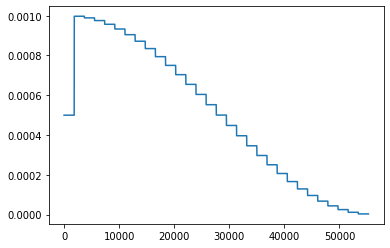

In [29]:
# learning rate schedule
plt.plot([i for i in range(len(lr_log))], lr_log);

In [30]:
dataset_test_A = MozTestDataset(audio_df_test_A, config.data_dir, min_length, audio_cache)

test_loader_A = torch.utils.data.DataLoader(
        dataset_test_A, batch_size=config_pytorch.batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )


dataset_test_B = MozTestDataset(audio_df_test_B, config.data_dir, min_length, audio_cache)

test_loader_B = torch.utils.data.DataLoader(
        dataset_test_B, batch_size=config_pytorch.batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )


In [31]:
# path and model name are used to save the PDF output
# but loading the model isn't needed unless the notebook
# has been restarted.  
path = '../outputs/models/pytorch/'
# model_name = 'model_e0_2022_03_19_17_06_24.pth'
#CDL_convnext_small_stfs_512_more_noise_rand_small_snd_framewise_model_e0_2022_03_20_07_39_47.pth_Test_B_cm
# model_name = 'model_e4_2022_03_27_12_41_05.pth'
model_name = 'model_e2_2022_03_27_22_13_59.pth'
model_name = 'model_e2_2022_03_28_12_12_01.pth'
model_name = 'model_e3_2022_03_28_12_48_54.pth'
model_name = 'model_e2_2022_03_28_23_01_29.pth'
model_name = 'model_e1_2022_03_29_09_57_52.pth'
model_name = 'model_e3_2022_03_30_17_07_11.pth'
model_name = 'model_e4_2022_03_30_19_42_55.pth' # 78
model_name = 'model_e0_2022_04_01_11_56_17.pth'
model_name = 'model_e4_2022_04_02_07_52_51.pth' ## 55 1.92
model_name = 'model_e4_2022_04_02_19_15_01.pth' #70 6
model_name = 'model_e9_2022_04_03_01_27_20.pth' #69 9
model_name = 'model_e7_2022_04_03_10_55_48.pth' #70
model_name = 'model_e8_2022_04_04_07_57_56.pth'
model_name = 'model_e13_2022_04_04_14_10_44.pth' #74 convnext_base_in22ft1k

model_name = 'model_e29_2022_04_04_16_54_46.pth' #convnext_base scratch

model_name = 'model_e24_2022_04_05_14_21_05.pth' # tf_efficientnetv2_b3

model_name = 'model_e19_2022_04_05_19_22_56.pth'
 

model = load_model(path + model_name, model)


Training on cuda:0


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/models/pytorch/model_e19_2022_04_05_19_22_56.pth'

In [ ]:
## feat_type is a unique name for the combination of paramters and pre-processing
feat_type = 'CDL_tf_efficientnetv2_b3_scratch_1024_128_no_more_noise_rand_small_snd_framewise_tf_mask_2_class_avgmax_3_chan'

In [ ]:
# error analysis to CSV in ../data/errors/{model_name}
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
audio_df_test_B['correct'] = np.equal(y_test_B.squeeze().numpy(), torch.argmax(y_preds_all.squeeze(),dim=1).numpy())
audio_test_B_correct = audio_df_test_B[['id','correct']].groupby('id').agg({'correct':['sum','count']})
audio_test_B_correct[('correct','incorrect')] = audio_test_B_correct[('correct','count')]-audio_test_B_correct[('correct','sum')]
audio_test_B_correct.to_csv(f'../outputs/errors/{model_name}_errors_windows.csv')

In [ ]:
audio_test_B_correct

### Test B

In [ ]:
# convnext 2 class
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)

PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')

In [ ]:
# convnext 2 class
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)

PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')

In [ ]:
# convnext 2 class
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)

PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')

In [ ]:
# convnext 2 class
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)

PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')

In [ ]:
# convnext 2 class
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)

PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')

### Test A

In [ ]:
y_preds_all, y_test_A = evaluate_model(model, test_loader_A, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_A, filename = feat_type + '_' + model_name +'_Test_A')

In [ ]:
# don't run this stuff.  Saved for reference

In [ ]:
from IPython.display import Audio, display

In [ ]:
plot_spectrogram(spec.cpu().detach().numpy()[0],title='512')

In [ ]:
sound, _ = _get_sample('../data/audio/199900.wav')

In [ ]:
display(Audio(sound.numpy()[0], rate=8000))

In [ ]:
spec = spec_layer(sound)  # (B, F, T)
spec = pcen_layer(spec)
spec = norm_layer(spec)

In [ ]:
pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
norm_layer = Normalization(mode='framewise')

In [ ]:
def _get_sample(path, resample=None):
    effects = [
        ["remix", "1"]
    ]
    if resample:
        effects.extend([
          #["lowpass", f"{resample // 2}"],
#             ["bandpass", f"600","1000"],
          ["rate", f'{resample}'],
          ['gain', '-n'],
         ["highpass", "600"],
        ])
    #returns waveform [1,XXXXX], sample_rate
    
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

In [ ]:
def _get_noisy_sample(path, noise_df):
    x, _ = _get_sample(path, resample=8000)
    sample_length = x.shape[1]/8000
    if len(noise_df[noise_df['length'] >= sample_length]) > 0:
        noise_path = noise_df[noise_df['length'] >= sample_length].sample(1).iloc[0]['path']
        noise, _ = _get_sample(noise_path, resample=8000)
        
        noise = noise[:, :x.shape[1]]

        mos_power = x.norm(p=2)
        noise_power = noise.norm(p=2)

        snr = math.exp(1 / 10)
        scale = snr * noise_power / mos_power
        x = (scale * x + noise) / 2
    return x

In [ ]:
x, _ = _get_sample('../data/audio/220371.wav', resample=8000)
sample_length = x.shape[1]/8000
noise_path = df_noise[df_noise['length'] >= sample_length].sample(1).iloc[0]['path']
noise, _ = _get_sample(noise_path, resample=8000)

noise = noise[:, :x.shape[1]]

In [ ]:
mos_power = x.norm(p=2)
noise_power = noise.norm(p=2)
mos_power, noise_power

In [ ]:
snr = math.exp(3 / 10)

In [ ]:
scale = snr * noise_power / mos_power

In [ ]:
scale

In [ ]:
x_n = (scale * x / 10 + noise) / 2

In [ ]:
x_n

In [ ]:
display(Audio(x_n, rate=8000))

In [ ]:
display(Audio(_get_sample(noise_path, resample=8000)[0].numpy()[0], rate=8000))

In [ ]:
display(Audio(_get_noisy_sample('../data/audio/220371.wav', noise_df=df_noise).numpy()[0], rate=8000))

In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
#     im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
plot_spectrogram(F.normalize(spec_layer(x.to('cuda:0')),dim=1).cpu().detach().numpy()[2])

In [ ]:
plot_spectrogram(spec_layer(x.to('cuda:0')).cpu().detach().numpy()[2])

In [ ]:
plot_spectrogram(tm(s[aug > 1]).cpu().detach().numpy()[0])

In [ ]:
## run this cell to list pretrained models
avail_pretrained_models = timm.list_models(pretrained=True)
avail_pretrained_models

In [ ]:
## put a model name in here to downlad a pretrained model and convert it
## to binary classification
pt_model = Model('beit_base_patch16_384',384)

In [ ]:
# look at layer names to figure out what to freeze
# You'll have to go edit the Model class and reload it based 
# on the model names you're freezing here
[name for name, _ in model.named_parameters()]

In [ ]:
timm.__version__